# Encontrando Transições de Fase com Machine Learning

* PET - Física UFRN
* Petiano: Tiago Pernambuco Toledo de Macêdo
* Data: 03/01/2025

## Importando Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import scipy as sp
from sklearn.cluster import KMeans
from tqdm import tqdm

## Detalhes das Bibliotecas

In [2]:
%load_ext version_information
%version_information Numpy, Scipy, Matplotlib, Pandas, Scikit-Learn, tqdm

Software versions
Python 3.11.9 64bit [MSC v.1938 64 bit (AMD64)]
IPython 8.29.0
OS Windows 10 10.0.22631 SP0
Numpy 2.1.3
Scipy 1.14.1
Matplotlib 3.9.2
Pandas 2.2.3
Scikit-Learn 1.6.0
tqdm 4.67.1
Thu Jan 02 13:19:46 2025 Hora Padrão de Buenos Aires

## 1. Introdução

$\quad$ O uso de métodos de Machine Learning em aplicação à física da matéria condensada é um fenômeno recente que vem atraindo muita atenção devido ao seu grande potencial de descrever sistemas físicos, uma das maiores aplicações sendo na identificação de transições de fases em sistemas quânticos de muitos corpos. Uma das formas através das quais isso pode ser feito é através de modelos de _clusterização_ de dados, que agrupam dados conforme sua semelhança. Um desses métodos é o K-Means Clustering, que separa os dados em K agrupamentos considerando as distâncias entre pontos diferentes. Neste notebook, aplicaremos o algoritmo K-Means Clustering para obter o diagrama de fase do célebre modelo ANNNI em 1D.

### 1.1. O Modelo ANNNI

$\quad$ O modelo _Axial Next-Nearest-Neighbor Ising_ (ANNNI) descreve um sistema de spins com interações entre primeiros vizinhos e segundos vizinhos ao longo de um eixo de simetria, além de interações de cada spin da rede com um campo magnético externo e transversal. O modelo ANNNI é razoavelmente simples, mas é de grande importância na física da matéria condensada devido ao seu rico diagrama de fases [1, 2]. O modelo ANNNI foi originalmente proposto em 1961 para descrever o ordenamento magnético em metais terras-raras [3].

$\quad$ Neste `Notebook`, trataremos do modelo ANNNI unidimensional, tal que temos uma cadeia de spins com o eixo de simetria ao longo da cadeia. Nos limitaremos também ao caso no qual as interações entre primeiros vizinhos são ferromagnéticas (tendem a alinhar os spins) enquanto as interações entre segundos vizinhos são antiferromagnéticas (tendem a anti-alinhar os spins). Nessa situação, o operador Hamiltoniano do nosso sistema se escreve:

$$ H = -J \left( \sum_{i = 0}^{N-1} \sigma_i^z \sigma_{i+1}^z - k\sum_{i = 0}^{N-1} \sigma_i^z \sigma_{i+2}^z + g\sum_{i = 0}^{N-1} \sigma_i^x  \right) .\tag{1}$$

Na expressão acima, $J$ é a intensidade da interação entre primeiros vizinhos, $k$ é a intensidade relativa (a $J$) da interação entre segundos vizinhos e $g$ é a intensidade relativa (também a $J$) do campo magnético externo. As matrizes $\sigma_i^\gamma$ ($\gamma = x, y, z$) são as matrizes de Pauli agindo no $i-ésimo$ spin e são definidas por:

$$\sigma_i^\gamma = \left[\bigotimes_{j = 0}^{i - 1} \mathbb{I}\right] \otimes \sigma^\gamma \otimes \left[\bigotimes_{j = i + 1}^{N - 1} \mathbb{I}\right]. \tag{2}$$

Onde $\otimes$ representa o produto tensorial e:

$$ \mathbb{I} = \begin{pmatrix} 1 && 0 \\ 0 && 1\end{pmatrix}. $$

$$ \sigma^x = \begin{pmatrix} 0 && 1 \\ 1 && 0\end{pmatrix}. $$

$$ \sigma^y = \begin{pmatrix} 0 && -i \\ i && 0\end{pmatrix}. $$

$$ \sigma^z = \begin{pmatrix} 1 && 0 \\ 0 && -1\end{pmatrix}. $$

### 1.2. K-Means Clustering

$\quad$ O algoritmo K-Means Clustering é, como o nome diz, um algoritmo de clusterização. Isso significa que, dado um conjunto de dados e um número de clusters (agrupamentos) $K$, o algoritmo busca separar os dados em $K$ grupos diferentes com base próximo de cada ponto do conjunto de dados com o centro do cluster mais próximo [4]. Não entraremos em muitos detalhes a respeito do funcionamento do método, mas é evidente, dada a sua descrição, que, dado um conjunto de observáveis adequado como dados, algoritmos como o K-Means devem ser capazes de identificar fases diferentes em um sistema físico.

## 2. Solução Numérica do Modelo ANNNI

$\quad$ A primeira coisa que devemos fazer para aplicar o algoritmo K-Means Clustering ao modelo ANNNI é obter os dados que passaremos ao modelo de clusterização. Neste `Notebook`, utilizaremos como dados médias de correladores das seguintes formas:

$$\langle \sigma_i^\gamma \sigma_{i+1}^\gamma\rangle,$$

$$\langle \sigma_i^\gamma \sigma_{i+2}^\gamma\rangle.$$

Onde os valores médios são calculados no estado fundamental do sistema. Este método foi proposta na referência [5]. Nele, estamos presumindo duas coisas:

- As informações relevantes sobre o ground state do modelo ANNNI são bem representadas por correlações entre primeiros e segundos vizinhos. Esta presunção é razoável, uma vez que cada spin só interage com seus primeiros e segundos vizinhos.
- Correlações entre spins em direções diferentes não carregam informações relevantes. Isto também é razoável, uma vez que, na definição do nosso Hamiltoniano na Equação (1), não há acoplamentos de interação além dos da forma $\sigma^\gamma \sigma^\gamma$.

$\quad$ Para obter esses correladores, vamos primeiro definir as matrizes de Pauli:

In [3]:
pauli_x = np.array([[0,1],[1,0]]) # Pauli X
pauli_y = np.array([[0,-1j],[1j,0]]) # Pauli Y
pauli_z = np.array([[1,0],[0,-1]]) # Pauli Z

$\quad$ Com as matrizes de Pauli definidas, podemos criar uma função para construir os operadores da forma descrita na Equação (2):

In [4]:
# A função Opi dado um operador (matriz) O, uma posição na cadeia de spins i e o número total de spins N, constrói um operador da forma da Equação (2).
def Opi(O,i, N):
    if(i<N):
        return sp.linalg.kron(sp.linalg.kron(np.identity(2**i), O),np.identity(2**(N-1-i)))
    elif(i==N):
        j=0
        return sp.linalg.kron(sp.linalg.kron(np.identity(2**j), O),np.identity(2**(N-1-j)))
    elif(i==N+1):
        j=1
        return sp.linalg.kron(sp.linalg.kron(np.identity(2**j), O),np.identity(2**(N-1-j)))

$\quad$ Na função acima, utilizamos as funções `sp.linalg.kron` da biblioteca Scipy para realizar o produto tensorial e `np.identity` do Numpy para evocar a matriz identidade.

$\quad$ Agora que temos os ingredientes básicos do nosso Hamiltoniano, construamos ele como está escrito na Equação (1):

In [5]:
# Dados os valores de N, J, k e g, essa função constrói o Hamiltoniano como na equação (1).
def Hamiltonian(N, J, k, g):
    # Inicializando o primeiro termo de H
    H1 =  np.zeros((2**N,2**N))

    # Inicializando o segundo termo de H
    H2 =  np.zeros((2**N,2**N))

    # Inicializando o terceiro termo de H
    H3 =  np.zeros((2**N,2**N))

    # Loop para somar cada termo dos somatórios. O operador de Python @ realiza o produto matricial.
    for i in range(N):
        H1 += Opi(pauli_z,i, N)@Opi(pauli_z,(i+1)%N, N)
        H2 += Opi(pauli_z,i, N)@Opi(pauli_z,(i+2)%N, N)
        H3 += Opi(pauli_x,i, N)

    # Multiplicando cada termo pelas constantes correspondentes
    Ham = -J*(H1 - k*H2 + g*H3)
    
    return Ham

$\quad$ Tendo esta função feita, podemos montar um Hamiltoniano para fazer um teste:

In [6]:
H = Hamiltonian(8, 1, 1/2, 1)

$\quad$ Vamos imprimir a sua forma matricial para visualizar melhor:

In [7]:
print(H)

[[-4. -1. -1. ... -0. -0. -0.]
 [-1. -2. -0. ... -0. -0. -0.]
 [-1. -0. -2. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -2. -0. -1.]
 [-0. -0. -0. ... -0. -2. -1.]
 [-0. -0. -0. ... -1. -1. -4.]]


$\quad$ Um bom teste para saber se o Hamiltoniano está consistente é verificar se ele é hermitiano, o que garante que seus autovalores (energias permitidas) do sistema são números reais. Podemos fazer isso com a função `sp.linalg.ishermitian()`:

In [8]:
sp.linalg.ishermitian(H)

True

$\quad$ Agora que temos a certeza de que nosso $H$ é hermitiano, usaremos a função `sp.linalg.eigh()` para calcular seus autovalores e autovetores de forma mais eficiente:

In [9]:
sp.linalg.eigh(H)

(array([-9.57113119e+00, -8.52009031e+00, -8.52009031e+00, -8.03093170e+00,
        -7.91179999e+00, -7.91179999e+00, -7.22079845e+00, -7.22079845e+00,
        -7.02614606e+00, -7.02614606e+00, -6.96935513e+00, -6.63046754e+00,
        -6.55184806e+00, -6.37572469e+00, -6.37572469e+00, -6.31234268e+00,
        -6.31234268e+00, -5.88207977e+00, -5.88207977e+00, -5.77343050e+00,
        -5.69772732e+00, -5.65683408e+00, -5.65683408e+00, -5.59750190e+00,
        -5.48646401e+00, -5.48646401e+00, -5.42243179e+00, -5.23933419e+00,
        -5.23933419e+00, -5.17880516e+00, -5.17880516e+00, -5.06417777e+00,
        -4.76334301e+00, -4.76334301e+00, -4.46975393e+00, -4.46975393e+00,
        -4.44852814e+00, -4.44852814e+00, -4.38099259e+00, -4.38099259e+00,
        -4.38071850e+00, -4.24804626e+00, -4.19631885e+00, -4.19631885e+00,
        -4.17134142e+00, -4.08006868e+00, -4.08006868e+00, -4.01784680e+00,
        -4.01784680e+00, -4.00000000e+00, -4.00000000e+00, -3.86136681e+00,
        -3.8

$\quad$ Agora que temos as funções necessárias para construir nosso sistema físico, vamos obter nossos dados e começar a aplicar o K-Means Clustering.

## 3. Encontrando Transições de Fase com K-Means Clustering

$\quad$ Para utilizar o K-Means Clustering, primeiro precisamos definir um conjunto com os observáveis que podemos querer analisar. Para tratar dos conjuntos de dados, utilizaremos os DataFrames da biblioteca Pandas:

In [10]:
data = pd.DataFrame() # Definindo o DataFrame do Pandas
data['k'] = [] # Guardar o valor de k
data['g'] = [] # Guardar o valor de g
data['E'] = [] # Guardar o valor de E, a energia do estado fundamental
data['GS'] = [] # Guardar o vetor de estado do estado fundamental, GS
data['PVX'] = [] # Guardar correladores entre primeiros vizinhos na direção x
data['SVX'] = [] # Guardar correladores entre segundos vizinhos na direção x
data['PVY'] = [] # Guardar correladores entre primeiros vizinhos na direção y
data['SVY'] = [] # Guardar correladores entre segundos vizinhos na direção y
data['PVZ'] = [] # Guardar correladores entre primeiros vizinhos na direção z
data['SVZ'] = [] # Guardar correladores entre segundos vizinhos na direção z

$\quad$ Como estaremos calculando muitos correladores, será útil definir funções para computá-los mais eficientemente:

In [11]:
# Esta função calcula uma única correlação da forma discutida na Seção 2.
def Corr(O, i, j, N, state):

    # Definindo os operadores
    Oi = Opi(O, i, N)
    Oj = Opi(O, j, N)

    # Calculando o valor esperado do produto de Oi e Oj
    corr = np.dot(np.conjugate(state.T),np.dot(Oi@Oj,state))
    
    return corr

In [12]:
# Esta função calcula todos os correladores relevantes para um dado Ground State de N spins.
def CorrsGS(ground_state, N):
    Corrs = {
    'PVX':[],
    'SVX': [],
    'PVY': [],
    'SVY':[],
    'PVZ':[],
    'SVZ': []
    }
    for i in range(N):
        Corrs["PVX"].append(Corr(O = pauli_x, i = i, j = i+1 , N = N, state = ground_state)) # Primeiros vizinhos em x
        Corrs["SVX"].append(Corr(O = pauli_x, i = i, j = i+2 , N = N, state = ground_state)) # Segundos vizinhos em x

        Corrs["PVY"].append(Corr(O = pauli_y, i = i, j = i+1, N = N, state = ground_state)) # Primeiros vizinhos em y
        Corrs["SVY"].append(Corr(O = pauli_y, i = i, j = i+2, N = N, state = ground_state)) # Segundos vizinhos em y

        Corrs["PVZ"].append(Corr(O = pauli_z, i = i, j = i+1, N = N, state = ground_state)) # Primeiros vizinhos em z
        Corrs["SVZ"].append(Corr(O = pauli_z, i = i, j = i+2, N = N, state = ground_state)) # Segundos vizinhos em z
    
    return Corrs

$\quad$ Com essas funções definidas, podemos passar ao loop principal para a obtenção dos dados. Calcularemos os valores dos correladores para diversos valores de $k$ e $g$ com $J = 1$ fixo para um sistema de $N = 8$ spins.

In [13]:
# Definindo passos e ranges de k e g
dk = 0.05
dg = 0.05
krange = np.arange(0, 1 + dk, dk)
grange = np.arange(0, 1 + dg, dg)

# Definindo vetores para guardar quantidades relevantes
kvec = []
gvec = []
Evec = []
GSvec = []
PVXvec = []
SVXvec = []
PVYvec = []
SVYvec = []
PVZvec = []
SVZvec = []

# Definindo constantes fixas
N = 8
J = 1

# Loop principal
for k in tqdm(krange):
    for g in grange:

        # Para cada par de valores de k e g, construimos o Hamiltoniano e computamos seus autovetores e autovalores
        Ham = Hamiltonian(N = N, J = J, k = k, g = g)
        autovalores, autovetores = sp.linalg.eigh(Ham)

        # Como estamos interessados no estado fundamental, tomamos apenas a menor autoenergia e seu autoestado correspondente
        E = autovalores[0]
        GS = autovetores[:, 0]

        # Utilizando a função CorrsGS para calcular os correladores
        Corrs = CorrsGS(GS, N)

        # Guardando os dados para estes k e g nos vetores
        kvec.append(k)
        gvec.append(g)
        Evec.append(E)
        GSvec.append(GS)

        # Guardando as médias dos correladores
        PVXvec.append(np.mean(Corrs['PVX']).real)
        SVXvec.append(np.mean(Corrs['SVX']).real)
        PVYvec.append(np.mean(Corrs['PVY']).real)
        SVYvec.append(np.mean(Corrs['SVY']).real)
        PVZvec.append(np.mean(Corrs['PVZ']).real)
        SVZvec.append(np.mean(Corrs['SVZ']).real)

# Guardando os vetores em nosso DataFrame
data['k'] = kvec
data['g'] = gvec
data['E'] = Evec
data['GS'] = GSvec
data['PVX'] = PVXvec
data['SVX'] = SVXvec
data['PVY'] = PVYvec
data['SVY'] = SVYvec
data['PVZ'] = PVZvec
data['SVZ'] = SVZvec

100%|██████████| 21/21 [01:18<00:00,  3.75s/it]


$\quad$ Agora que temos nossos dados, precisamos de mais uma coisa para aplicar o método K-Means Clustering: saber o número $K$ de clusters que queremos. Naturalmente, este valor deve ser o número de fases que o nosso sistema apresenta. Esse número, porém, é no geral desconhecido. Para estimá-lo, utilizaremos o chamado “Elbow Method”, ou “Método do Cotovelo”, em português. O método consiste em calcular a “Inércia” do conjunto de dados clusterizado para diferentes valores de $K$ e escolher o $K$ para o qual a Inércia começa a se estabilizar, mostrando convergência do método. A Inércia é definida como:

$$I = \sum_{i = 1}^{n} d(x_i, c_j^*)^2. $$

Onde $d(x_i, c_j^*)$ é a distância euclidiana entre o ponto $x_i$ e o centro do j-ésimo cluster, $c_j^*$ e $n$ é o número de valores no conjunto de dados.

$\quad$ Como o modelo ANNNI unidimensional é bastante simples, esperamos que não haja um número muito grande de fases. Determinaremos a Inércia para $K = 1,...,6$ para aplicar o método do cotovelo:

In [14]:
Inertia = []
for i in range(1, 7):
    # Inicializando o modelo KMeans
    km = KMeans(n_clusters = i, init = 'k-means++', algorithm = 'lloyd')

    # Fazendo o fit do modelo aos nossos dados dos correladores apenas
    km.fit(data.drop(['k', 'g', 'E', 'GS'], axis = 'columns'))
    Inertia.append(km.inertia_)

$\quad$ Com os valores de inércia calculados, plotemos eles em um gráfico:

Text(0, 0.5, 'Inércia')

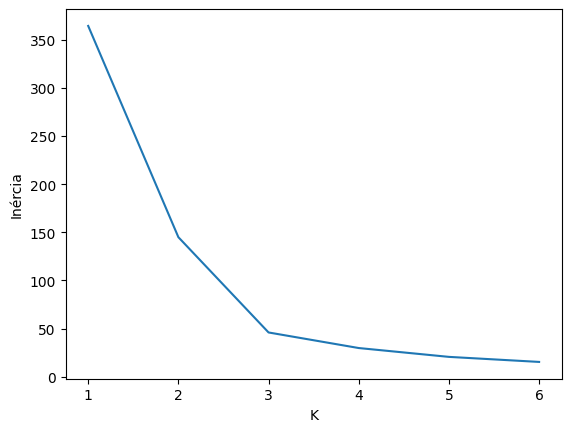

In [15]:
plt.plot(range(1, 7), Inertia)
plt.xlabel('K')
plt.ylabel("Inércia")

$\quad$ Podemos claramente ver que entre $K = 3$ e $K = 4$, o comportamento do gráfico muda bastante, tendendo a se estabilizar. Isso indica que devemos procurar 3 ou 4 fases diferentes no nosso modelo. Façamos a análise primeiro para 3:

In [16]:
# Definindo o modelo para K = 3
model = KMeans(n_clusters = 3, init = 'k-means++', algorithm = 'lloyd')

In [17]:
# Realizando o fit dos dados
model.fit(data.drop(['k', 'g', 'E', 'GS'], axis = 'columns'))

KMeans(n_clusters=3)

$\quad$ Vamos agora visualizar como o K-Means Clustering classificou cada um dos pontos do nosso conjunto de dados e onde estão os centros de cada cluster no plano cartesiano:

In [18]:
model.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [19]:
model.cluster_centers_

array([[ 0.70690739,  0.59429026, -0.33881537,  0.12912511,  0.34975381,
        -0.06009433],
       [ 0.13183456,  0.18267027, -0.05474182,  0.10039078,  0.01687506,
        -0.89529204],
       [ 0.14866386,  0.09664105, -0.07354114, -0.00555824,  0.91432825,
         0.89360537]])

$\quad$ A título de comparação, vamos plotar junto aos nossos resultados as curvas das transições de fase como encontradas na referência [6]. Os arquivos com os dados destas curvas estarão disponíveis no [github do PET.py](https://github.com/PETfisicaUFRN/PET.py/tree/main/Dados) sob os nomes de Transições.txt e KT.txt.

In [22]:
trans = pd.read_csv(r'C:\Users\tiago\OneDrive\Documentos\GitHub\PET.py\Dados\Encontrando Transições de Fase com Machine Learning\Transições.txt', sep = ';', decimal = ',')
KT = pd.read_csv(r'C:\Users\tiago\OneDrive\Documentos\GitHub\PET.py\Dados\Encontrando Transições de Fase com Machine Learning\KT.txt', sep = ';', decimal = ',')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tiago\\OneDrive\\Documentos\\GitHub\\PET.py\\Dados\\Encontrando Transições de Fase com Machine Learning\\Transições.txt'

NameError: name 'trans' is not defined

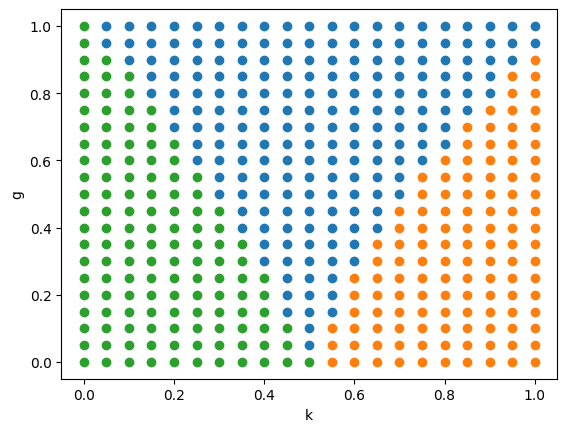

In [21]:
# Plotando o diagrama de fase e as linhas de transição
plt.scatter(data['k'][model.labels_==0], data['g'][model.labels_==0])
plt.scatter(data['k'][model.labels_==1], data['g'][model.labels_==1])
plt.scatter(data['k'][model.labels_==2], data['g'][model.labels_==2])
plt.xlabel('k')
plt.ylabel('g')
plt.plot(trans['x'], trans['y'], color = 'black')
plt.plot(KT['x'], KT['y'], color = 'black')

$\quad$ Um primeiro ponto a se comentar é que, como visível pelas linhas de transição, há 4 fases no diagrama completo do modelo ANNNI. São elas a fase ferromagnética, fase paramagnética, “antifase” e a “fase flutuante”. Notamos que a linha que divide as fases ferromagnética e paramagnética (regiões azul e verde, respectivamente) é quase perfeitamente reproduzida pelo método K-Means. A linha que divide as fases paramagnética e flutuante é qualitativamente reproduzida, ainda que com erros quantitativos. Analisemos agora o que acontece quando tomamos 4 clusters ao invés de 3:

In [223]:
# Definindo o modelo para K = 4
model = KMeans(n_clusters = 4, init = 'k-means++', algorithm = 'lloyd')

In [224]:
# Realizando o fit dos dados
model.fit(data.drop(['k', 'g', 'E', 'GS'], axis = 'columns'))

C:\Users\tiago\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=4)

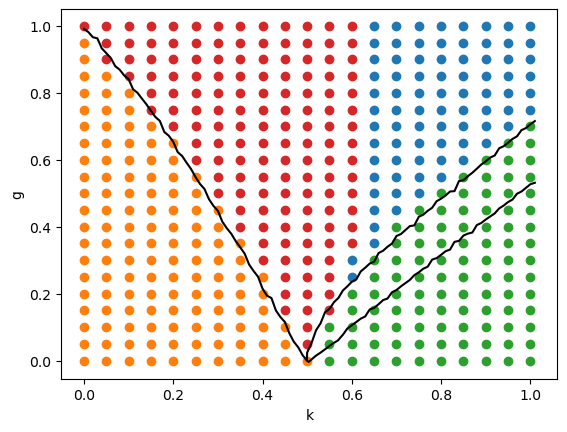

In [225]:
# Plotando o diagrama de fase e as linhas de transição
plt.scatter(data['k'][model.labels_==0], data['g'][model.labels_==0])
plt.scatter(data['k'][model.labels_==1], data['g'][model.labels_==1])
plt.scatter(data['k'][model.labels_==2], data['g'][model.labels_==2])
plt.scatter(data['k'][model.labels_==3], data['g'][model.labels_==3])
plt.xlabel('k')
plt.ylabel('g')
plt.plot(trans['x'], trans['y'], color = 'black')
plt.plot(KT['x'], KT['y'], color = 'black')

$\quad$ Desta vez, ocorreu algo curioso. Embora a precisão da linha que divide as fases paramagnética e flutuante tenha melhorado, o K-Means Clustering ao invés de reconhecer a diferença entre a fase flutuante e a antifase, reconhece uma outra região dentro da fase paramagnética. A referência [5] fornece evidências de que, para sistemas maiores, essa nova transição identificada para corresponder à chamada "Linha de Emery-Peschel", que divide a fase paramagnética nas fases paramagnéticas comensurada e incomensurada. Vale notar que essa linha não corresponde a uma transição de fase propriamente dita, mas a uma sutil mudança no comportamento do sistema, que ainda é paramagnético. 

$\quad$ Ficamos ainda, porém, com o fato de que o método K-Means falha em identificar a transição ilustrada na linha inferior direita no gráfico acima. Esse fato se dá pois a transição é de caráter altamente não-trivial, sendo assim, provavelmente não é bem representada pelo detalhe reduzido que obtemos ao considerar apenas correlações entre primeiros e segundos vizinhos como os dados utilizados para classificar as fases.

$\quad$ Mesmo considerando esta falha, porém, vemos que métodos como o K-Means Clustering tem um grande potencial de auxiliar na descrição de transições de fase em sistemas de matéria condensada, tendo apresentado resultados bastante consistentes em uma análise extremamente simples e rápida para um sistema pequeno. Como a estrutura de um sistema de spins só é totalmente bem definida no limite termodinâmico ($N \rightarrow \infty$), este é outro fator que contribui para as falhas observadas. Considerando isso tudo, notamos que nossos resultados são bastante positivos.

## 4. Conclusão

$\quad$ Neste `Notebook`, aplicamos o método de Machine Learning conhecido como K-Means Clustering para identificar transições de fase no estado fundamental do modelo Axial Next-Nearest-Neighbor Ising (ANNNI). Começamos com uma breve explicação do modelo ANNNI e como construir seu Hamiltoniano. Isso feito, passamos a solucionar numericamente com métodos matriciais o modelo, obtendo suas autoenergias e seus autoestados. Com isso, calculamos correlações entre primeiros e segundos vizinhos para utilizar como dados para clusterizar com o K-Means.

$\quad$ Aplicando o método K-Means Clustering, observando que, mesmo com uma quantidade pequena de dados extremamente simples e pouco tempo de processamento, nossa técnica de aprendizado de máquina não-supervisionado foi capaz de identificar com bastante precisão duas das três transições de fase presentes no diagrama de fase do modelo ANNNI, indicando um bom desempenho e um excelente potencial de desenvolvimento no futuro, especialmente considerando métodos mais complexos e maiores quantidades de dados.

---

## 5. Referências

[1] J. Villain and P. Bak, “Two-dimensional ising model with competing interactions : floating phase, walls and dislocations, ” Journal de Physique 42, 657–668 (1981).

[2] Heiko Rieger and Genadi Uimin, “The one-dimensional ANNNI model in a transverse field: analytic and numerical study of effective hamiltonians, ” Zeitschriftfür Physik B Condensed Matter 101, 597–611 (1996).

[3] R. J. Elliott, “Phenomenological discussion of magnetic ordering in the heavy rare-earth metals,” Phys. Rev. 124, 346–353 (1961).

[4] Hartigan, J. A., & Wong, M. A. (1979). A k-means clustering algorithm. Applied statistics, 28(1), 100-108.

[5] Askery Canabarro, Felipe Fernandes Fanchini, André Luiz Malvezzi, Rodrigo Pereira, and Rafael Chaves, “Unveiling phase transitions with machine learning,” Phys. Rev. B 100, 045129 (2019).

[6] M. Cea, M. Grossi, S. Monaco, E. Rico, L. Tagliacozzo, and S. Vallecorsa, “Exploring the phase diagram of the quantum one-dimensional annni model,” (2024), arXiv:2402.11022 [cond-mat.str-el].